In [1]:
import os

import numpy as np
import xarray as xr
import cfgrib
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

from dask.distributed import Client, LocalCluster

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16, "axes.labelsize":16, "axes.titlesize":16,
                     "font.weight": "bold","axes.labelweight":"bold","axes.titleweight":"bold",
                    "figure.titleweight":"bold", "figure.titlesize":"large" })

from ambiance import Atmosphere
from aostools import climate

from Eval import plot_map_xr, plot_profile_xr, make_gif
from Eval import var_info, coord_info, results_dir


In [2]:
# Make an atmosphere object
heights = np.linspace(-5e3, 80e3, num=1000)
atmosphere = Atmosphere(heights)

/home/ap1_12/.conda/envs/nwp-py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


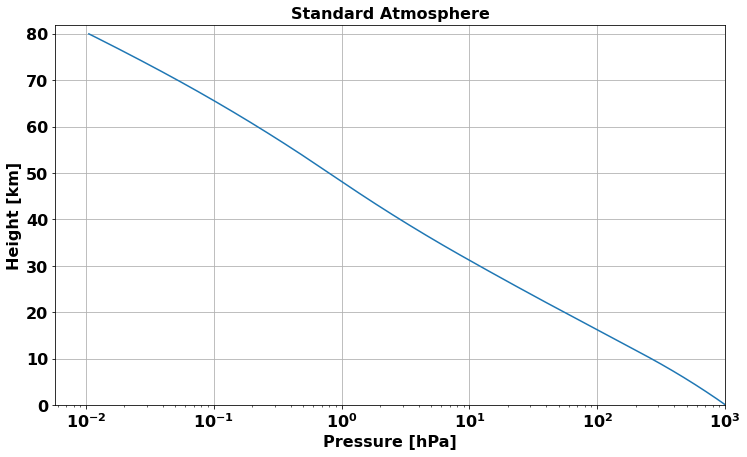

In [3]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(atmosphere.pressure/100, heights/1000)

ax.set_xscale('log')

ax.set_ylim(0,82)
ax.set_xlim(-20,1000)

ax.set_title('Standard Atmosphere')
ax.set_ylabel('Height [km]')
ax.set_xlabel('Pressure [hPa]')
ax.grid()
fig.show()

# Open dataset

In [4]:
dataset = 'icon'

In [5]:
data_dir = '/gemeinsam_tmp/SSW_2021/'

In [6]:
#client = Client(LocalCluster(host='192.168.154.3')) # change to ora's IP adress: 192.168.135.33
client = Client(LocalCluster(host='192.168.155.33'))

In [7]:
client

Client Scheduler: tcp://192.168.155.33:45235 Dashboard: http://192.168.155.33:8787/status,Cluster Workers: 8 Cores: 64 Memory: 810.22 GB


## ICON

In [8]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}dwd/analysis_new/igar??????????'
ds_icon = xr.open_mfdataset(
    infiles,
    engine='cfgrib',
    combine='nested',
    concat_dim = 'time',
    parallel = True,
    backend_kwargs={'filter_by_keys': filter_by_keys},
)

In [ ]:
ds_icon

### Chunk the array

### Test Plots

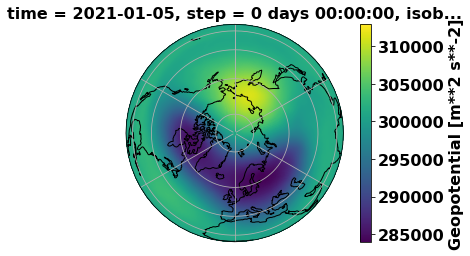

In [9]:
p = ds_icon['z'].sel(
    isobaricInhPa=10,
    time = '2021-01-05T00'
    ).plot(
        subplot_kws=dict(projection=ccrs.Orthographic(0, 90)), 
        transform=ccrs.PlateCarree(),
        #robust = True
)
p.axes.set_global()
p.axes.coastlines()
p.axes.gridlines()

## testtt


In [12]:
var = 'u'
t = ds_icon.time[0]

sel = ds_icon[var].sel(**{coord_info.get(dataset).get('time'): t.data},).load()

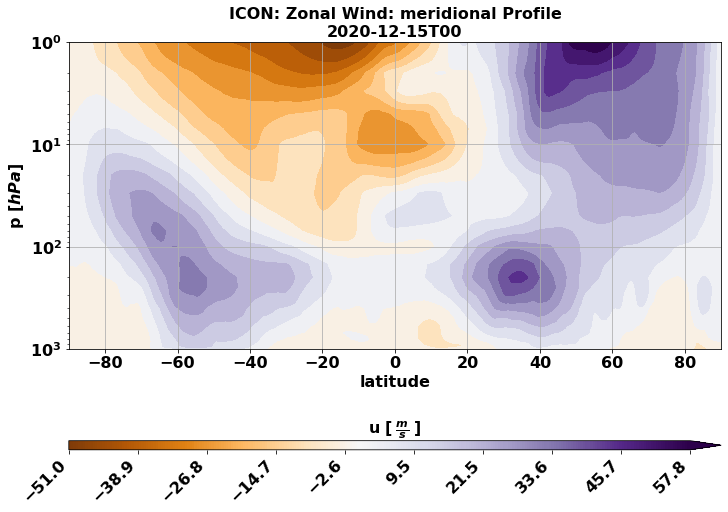

In [13]:
plot_profile_xr(sel, t, dataset=dataset,  mode='meridional',
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=20,
                save=False )

### Plot u meridional profiles: ~2 min

In [ ]:
var = 'u'

In [ ]:
sel_all = ds_icon[var].sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
#               **{coord_info.get(dataset).get('p'): slice(500, 1)}
).load()

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data},) 
  
    plot_profile_xr(sel, t, dataset=dataset,  mode='meridional',
                    norm_bound=(mini, maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=20,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/u_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Plot t meridional profiles: ~2 min

In [ ]:
var = 't'

In [ ]:
sel_all = ds_icon[var].sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
#               **{coord_info.get(dataset).get('p'): slice(500, 1)}
).load()

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data},)
    
    plot_profile_xr(sel, t, dataset=dataset, mode='meridional',
                    norm_bound=(mini, maxi), norm_type = 'linear', 
                    cmap = plt.cm.Reds, levels=20, 
                    save=True, )

In [ ]:
file_folder = results_dir.get(dataset) + '/t_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Plot t (°C) meridional profiles: ~2 min

In [ ]:
var = 't'

In [ ]:
sel_all = ds_icon[var].sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
#               **{coord_info.get(dataset).get('p'): slice(500, 1)}
).load() - 273.15
sel_all = sel_all.rename('tc')

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data},)
    
    plot_profile_xr(sel, t, dataset=dataset, mode='meridional',
                    norm_bound=(mini, maxi), norm_type = 'diverging', 
                    cmap = plt.cm.RdBu_r, levels=20, 
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/tc_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Plot Geopotential maps: ~10 min

In [ ]:
p_level = 10
var = 'z'

In [ ]:
sel_all = ds_icon[var].sel(
                **{coord_info.get(dataset).get('lat'): slice(0, 90)},
                **{coord_info.get(dataset).get('p'): p_level},
                ).compute()
maxi = sel_all.max().data
mini = sel_all.min().data

In [ ]:
for t in sel_all.time:
    icon_plot = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data})
    plot_map_xr(icon_plot, t, dataset=dataset, figsize=(6,6),
             projection=ccrs.Orthographic(central_longitude=0, central_latitude=90),
             norm=True, norm_bound=(mini, maxi), norm_type='linear',
             levels=20, cmap=plt.cm.Purples,
             save=True
             )

In [ ]:
file_folder = results_dir.get(dataset) + 'z_' + str(int(p_level)) + 'hPa'
make_gif(file_folder, dataset=dataset, duration=150)

### Plot Temperature (°C) maps: ~10 min

In [ ]:
p_level = 10
var = 't'

In [ ]:
sel_all = ds_icon[var].sel(
                **{coord_info.get(dataset).get('lat'): slice(0, 90)},
                **{coord_info.get(dataset).get('p'): p_level},
                ).load() - 273.15

sel_all = sel_all.rename('tc')

maxi = sel_all.max().data
mini = sel_all.min().data

In [ ]:
for t in sel_all.time:
    icon_plot = sel_all.sel(**{coord_info.get(dataset).get('time'): t.data})
    plot_map_xr(icon_plot, t, dataset=dataset, figsize=(6,6),
             projection=ccrs.Orthographic(central_longitude=0, central_latitude=90),
             norm=True, norm_bound=(mini,0, maxi), norm_type='diverging',
             levels=20, cmap=plt.cm.RdBu_r,
             save=True
             )

In [ ]:
file_folder = results_dir.get(dataset) + '/tc_' + str(int(p_level)) + 'hPa'
make_gif(file_folder, dataset=dataset, duration=150)

### Plot Geopotential profiles: ~10 min

# EP Flux tests

In [14]:
t = ds_icon.time[0:5]

In [15]:
test_data = ds_icon.sel(
    #isobaricInhPa=10,
    time = t.data
    ).load()

In [16]:
test_data.dims

Frozen(SortedKeysDict({'time': 5, 'isobaricInhPa': 25, 'latitude': 721, 'longitude': 1440}))

In [17]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'],test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [18]:
ep1.dims, ep1.shape

(('time', 'isobaricInhPa', 'latitude'), (5, 25, 721))

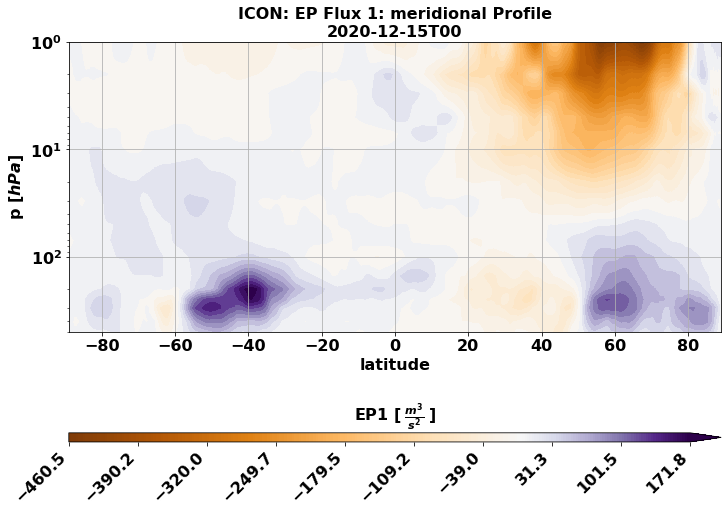

In [25]:
t = ep1.time[0]

sel = ep1.sel(time = t.data,
                    **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
                   **{coord_info.get(dataset).get('p'): slice(500, 1)}) 

#norm_bound=(-0.5, 0.5)

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

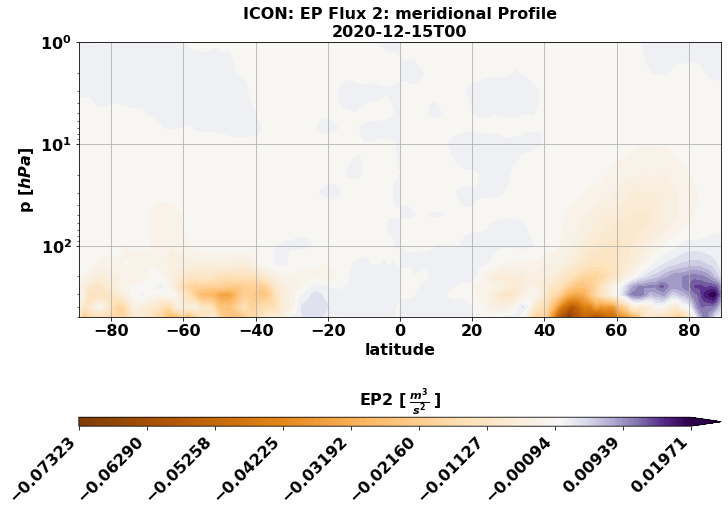

In [24]:
t = ep1.time[0]

sel = ep2.sel(time = t.data,
                   **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
                   **{coord_info.get(dataset).get('p'): slice(500, 1)}
                  ) 

#norm_bound=(-0.5, 0.5)

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

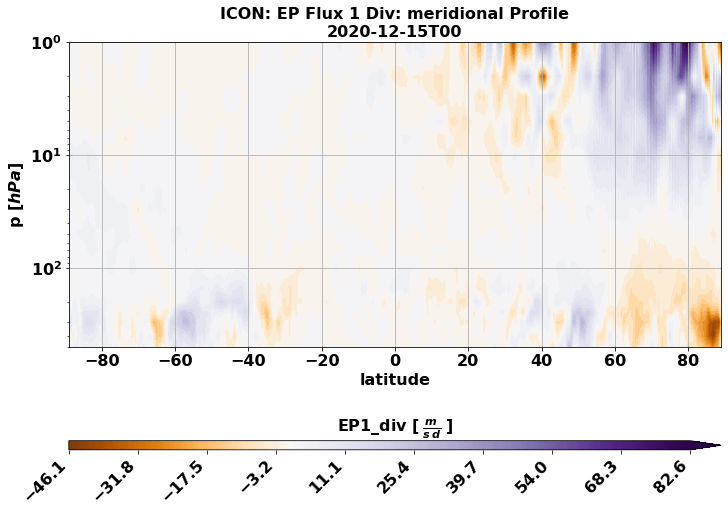

In [23]:
t = ep1.time[0]

sel = ep1_div.sel(time = t.data,
                       **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
                       **{coord_info.get(dataset).get('p'): slice(500, 1)},
                      ) 

norm_bound=(-1e+2,1e+2)

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

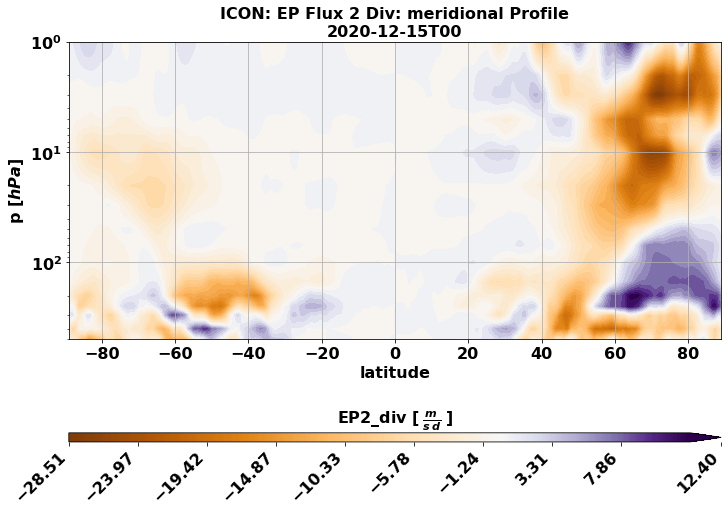

In [22]:
t = ep1.time[0]

sel = ep2_div.sel(time = t.data)
sel = sel.sel(
                **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500,1)},
             ) 
                       

# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

### Compote EP Eddy Heat

In [ ]:
test_data = ds_icon.sel(
    **{coord_info.get(dataset).get('p'): slice(20, 5)},
    **{coord_info.get(dataset).get('lat'): slice(45, 75)}
       ).load()

In [ ]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'], test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [ ]:
ep2.sel(**{coord_info.get(dataset).get('p'): 10},
        **{coord_info.get(dataset).get('lat'): 50}
       ).plot()

## Compute whole timeseries EP (loading data ~5:30 min | EP calc ~2:30 min)

In [ ]:
test_data = ds_icon.load()

In [ ]:
ep1, ep2, ep1_div, ep2_div = climate.ComputeEPfluxDivXr(test_data['u'], test_data['v'], test_data['t'],
                lat=coord_info.get(dataset).get('lat'), lon=coord_info.get(dataset).get('lon'),
                pres=coord_info.get(dataset).get('p'), time=coord_info.get(dataset).get('time') )

ep1.name = 'EP1'
ep2.name = 'EP2'
ep1_div.name = 'EP1_div'
ep2_div.name = 'EP2_div'

In [ ]:
ep2.sel(**{coord_info.get(dataset).get('p'): 10},
        **{coord_info.get(dataset).get('lat'): 50}
       ).plot()

### Compute EP1 profile series ~ 1 min

In [ ]:
sel_all = ep1.sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 
    
    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP1_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Compute EP2 profile series ~ 1 min

In [ ]:
sel_all = ep2.sel(
#               **{coord_info.get(dataset).get('lat'): slice(0, 10)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP2_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Compute EP1_div profile series ~ 1 min

In [ ]:
sel_all = ep1_div.sel(
              **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP1_div_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

### Compute EP2_div profile series ~ 1 min

In [ ]:
sel_all = ep2_div.sel(
              **{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/EP2_div_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)

# VMFC
vmfc_20201215_20210107.nc

In [26]:
filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
infiles = f'{data_dir}dwd/analysis_new/vmfc_20201215_20210107.nc'
ds_icon_vmfc = xr.open_mfdataset(
    infiles,
    #engine='cfgrib',
    #combine='nested',
    #concat_dim = 'time',
    parallel = True,
    #backend_kwargs={'filter_by_keys': filter_by_keys},
).load()


In [ ]:
ds_icon_vmfc.time

In [28]:
t = ds_icon_vmfc.time[0]

sel = ds_icon_vmfc['vmfc'].sel(time = t.data)
sel = sel.sel(
            #**{coord_info.get(dataset).get('lat'): slice(-89, 89)},
            **{coord_info.get(dataset).get('p'): slice(500,1)},
             )

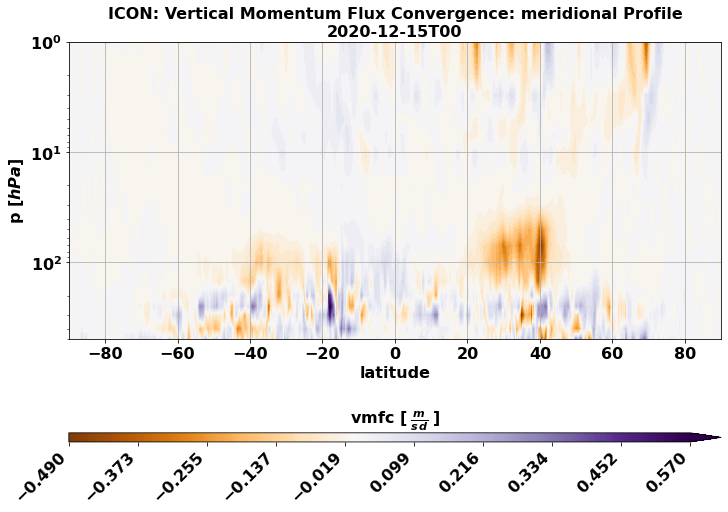

In [29]:
# meridional    zonal
plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                norm_bound=None, norm_type = 'diverging', 
                cmap = plt.cm.PuOr, levels=50,
                save=False )

### Compute VMFC profile series ~ 1 min

In [ ]:
sel_all = ds_icon_vmfc['vmfc'].sel(
              #**{coord_info.get(dataset).get('lat'): slice(-89, 89)},
              **{coord_info.get(dataset).get('p'): slice(500, 1)})

mini = sel_all.min().data
maxi = sel_all.max().data

for t in sel_all.time:
    sel = sel_all.sel(time = t.data) 

    plot_profile_xr(sel, t, dataset=dataset, mode='meridional', average = False,
                    norm_bound=(mini,maxi), norm_type = 'diverging', 
                    cmap = plt.cm.PuOr, levels=50,
                    save=True )

In [ ]:
file_folder = results_dir.get(dataset) + '/vmfc_meridional_profile'
make_gif(file_folder, dataset=dataset, duration=150)